In [1]:
LOCAL = False

#from Bio.SeqIO.FastaIO import SimpleFastaParser
import numpy as np
import os, sys
import pandas as pd
import pybedtools as pb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import linear_model
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.formula.api import ols
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")


if LOCAL is True:
    sys.path.append("/Users/sarahfong/tools/py_")
    PATH = "/Users/sarahfong/Desktop/local_data/Biomarin_Jun_2023/"
    RE = os.path.join(PATH, "results")
    CONFIG_NAME="config.local.neuron.mpra.ini"
    RE_MAPS = os.path.join(RE, "enh_maps")
else:
    PATH="/wynton/group/ahituv/fongsl/projects/biomarin/data"
    RE = "/wynton/group/ahituv/fongsl/projects/biomarin/results"
    RE_MAPS = os.path.join(RE, "enh_maps")
    CONFIG_NAME="config.neuron.mpra.orig.ini"

# nomination dataframe
NOMS = os.path.join(PATH, "GABA_GLUT_DF.for.noms.tsv")

import config_readwrite as crw
import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

In [2]:
config, cfn = crw.read(CONFIG_NAME)

section = 'lib2'
crw.check(config, section)

In [3]:
MPRA = config[section]["delta.mpra_richa"]
DELTA_ACTIVITY = config[section]["delta.mpra_centered"]
DELTA_ACTIVITY_Z = config[section]["delta.mpra_centeredz"]

FASTA = config[section]["fasta"]

TILE_BED = config[section]["tile_bed"]
ENH_BED = config[section]["enh_bed"]

GREAT_GENE_TSV = config[section]["great_nearest"]
META_DATA = config[section]["metadata"]

SIG_ACTIVITY_Z = config[section]["sig-wilcoxon"]
VISTA = config[section]["vista"]

SUPPORT = config[section]["support"] # neighboring tile support
BKGD = config[section]["bkgd"] # neighboring tile support
TFBS = config["tfbs2"]["vierstra.motif.loc.nored"] # TFBS archetypes where score is in 95% of motif scores, binned by length, no redundants
    # i.e. the strongest of the motif matches. 

In [4]:
DENG_PATH='/wynton/group/ahituv/fongsl/projects/biomarin/data/Deng_2024_MPRA_allele/'
DENG_ALLELES=os.path.join(DENG_PATH, "DataS2-Variant-library-ratios.xlsx")
ALLELE_BED = os.path.join(DENG_PATH, "allele.bed")
OLIGO_BED = os.path.join(DENG_PATH, "mpra_oligo_allele.bed")

In [5]:
allele_df = pd.read_excel(DENG_ALLELES, sheet_name="Primary")
allele_df.head()

,rsid,variant_chrom,variant_pos,insert_name,alt_ref_ratio,alt_ratio,ref_ratio,alt_is_active,ref_is_active,logFC,...,abc_target_gene_name_RG,abc_target_gene_name_ulEN,qtl_conservation,qtl_motifbreakr_gene_name,qtl_motifbreakr_effect_size,qtl_motifbreakr_effect,qtl_target_id,qtl_target_name,qtl_target_tpm_mean,insert_conservation_mean
0,rs61769717,chr1,920661,chr1:920526-920796,0.997264,1.131237,1.134341,1,1,0.002051,...,NaN,NaN,0.129,NaN,NaN,NaN,ENSG00000272438,NaN,NaN,-0.454211
1,rs7414599,chr1,920949,chr1:920814-921084,1.036923,1.281444,1.235815,1,1,0.066290,...,NaN,NaN,-0.997,KLF5,-0.130319,strong,ENSG00000272438,NaN,NaN,-0.253456
2,rs4072383,chr1,935954,chr1:935819-936089,0.997247,0.612234,0.613924,0,0,0.065002,...,NaN,NaN,0.857,NaN,NaN,NaN,ENSG00000187634,SAMD11,1.863148,0.837900
3,rs7417106,chr1,976215,chr1:976080-976350,1.135937,1.423786,1.253403,1,1,0.188716,...,NaN,NaN,0.054,SP2,0.101200,strong,ENSG00000179403,VWA1,8.334487,0.092148
4,rs4970392,chr1,1025029,chr1:1024894-1025164,NaN,NaN,1.191425,0,1,NaN,...,NaN,NaN,-0.174,EGR2,0.145979,strong,ENSG00000188157,AGRN,118.345398,-0.504348


In [6]:
allele_df[['rsid',
 'variant_chrom',
 'variant_pos',
 'insert_name',
 'alt_ref_ratio',
 'alt_ratio',
 'ref_ratio',
 'alt_is_active',
 'ref_is_active',
 'logFC',
 'AveExpr',
 't',
 'P.Value',
 'adj.P.Val',]]

,rsid,variant_chrom,variant_pos,insert_name,alt_ref_ratio,alt_ratio,ref_ratio,alt_is_active,ref_is_active,logFC,AveExpr,t,P.Value,adj.P.Val
0,rs61769717,chr1,920661,chr1:920526-920796,0.997264,1.131237,1.134341,1,1,0.002051,0.187994,0.033502,0.973812,0.996417
1,rs7414599,chr1,920949,chr1:920814-921084,1.036923,1.281444,1.235815,1,1,0.066290,0.324498,0.962709,0.354239,0.778161
2,rs4072383,chr1,935954,chr1:935819-936089,0.997247,0.612234,0.613924,0,0,0.065002,-0.715820,0.437921,0.669035,0.923794
3,rs7417106,chr1,976215,chr1:976080-976350,1.135937,1.423786,1.253403,1,1,0.188716,0.422401,2.768734,0.016668,0.228121
4,rs4970392,chr1,1025029,chr1:1024894-1025164,NaN,NaN,1.191425,0,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15906,rs3750517,chr9,137063844,chr9:137063709-137063979,0.956024,1.049311,1.097578,0,1,-0.071944,0.113525,-0.984400,0.343888,0.771386
15907,rs867476,chr9,137064131,chr9:137063996-137064266,0.896897,0.983655,1.096732,0,1,-0.147669,0.066097,-2.216027,0.046256,0.369420
15908,rs7390710,chr9,137079177,chr9:137079042-137079312,NaN,NaN,0.795953,0,0,NaN,NaN,NaN,NaN,NaN
15909,rs7037849,chr9,137079368,chr9:137079233-137079503,1.021186,0.961629,0.941679,0,0,0.031658,-0.066888,0.523616,0.609851,0.902767


In [7]:
allele_df[[ 'alt_ref_ratio', 'logFC',
 'AveExpr',
 't',
 'P.Value',
 'adj.P.Val',]].describe()

,alt_ref_ratio,logFC,AveExpr,t,P.Value,adj.P.Val
count,15335.000000,15335.000000,15335.000000,15335.000000,1.533500e+04,1.533500e+04
mean,1.004251,-0.001313,-0.132794,-0.021088,4.303875e-01,7.211765e-01
std,0.107214,0.147566,0.540966,1.779402,3.070708e-01,2.601629e-01
min,0.300686,-1.733034,-3.090478,-20.603739,8.620083e-12,1.321890e-07
25%,0.951982,-0.070253,-0.271723,-0.876118,1.470911e-01,5.882494e-01
50%,0.999815,0.000250,0.046343,0.004007,4.028284e-01,8.054392e-01
75%,1.048915,0.068235,0.207118,0.855172,6.993335e-01,9.322408e-01
max,3.243177,1.696647,0.970758,24.400236,9.997180e-01,9.997180e-01


# make an allele bed

In [8]:
allele_bed = allele_df[['rsid',
 'variant_chrom',
 'variant_pos',
 'insert_name',
 'alt_ref_ratio',
 'alt_ratio',
 'ref_ratio',
 'alt_is_active',
 'ref_is_active',
 'logFC',
 'AveExpr',
 't',
 'P.Value',
 'adj.P.Val',]].copy()

In [9]:
# variant_pos - 1 from section 4 examples in https://genome-blog.gi.ucsc.edu/blog/2016/12/12/the-ucsc-genome-browser-coordinate-counting-systems/
allele_bed["variant_pos-1"] = allele_bed["variant_pos"] - 1

allele_col_order = [
    'variant_chrom',
    'variant_pos-1',
    'variant_pos',
    'rsid',
    'insert_name',
    'alt_ref_ratio',
    'alt_ratio',
    'ref_ratio',
    'alt_is_active',
    'ref_is_active',
    'logFC',
    'AveExpr',
    't',
    'P.Value',
    'adj.P.Val',
]
allele_bed=allele_bed[allele_col_order]  
allele_bed.rename(columns={"variant_chrom":"#variant_chrom"}, inplace=True)
allele_bed.to_csv(ALLELE_BED, sep='\t', index=False) 
allele_bed.head()

,#variant_chrom,variant_pos-1,variant_pos,rsid,insert_name,alt_ref_ratio,alt_ratio,ref_ratio,alt_is_active,ref_is_active,logFC,AveExpr,t,P.Value,adj.P.Val
0,chr1,920660,920661,rs61769717,chr1:920526-920796,0.997264,1.131237,1.134341,1,1,0.002051,0.187994,0.033502,0.973812,0.996417
1,chr1,920948,920949,rs7414599,chr1:920814-921084,1.036923,1.281444,1.235815,1,1,0.066290,0.324498,0.962709,0.354239,0.778161
2,chr1,935953,935954,rs4072383,chr1:935819-936089,0.997247,0.612234,0.613924,0,0,0.065002,-0.715820,0.437921,0.669035,0.923794
3,chr1,976214,976215,rs7417106,chr1:976080-976350,1.135937,1.423786,1.253403,1,1,0.188716,0.422401,2.768734,0.016668,0.228121
4,chr1,1025028,1025029,rs4970392,chr1:1024894-1025164,NaN,NaN,1.191425,0,1,NaN,NaN,NaN,NaN,NaN


# make an oligo bed

In [10]:
# copy_dataframe_columns
oligo_bed = allele_df[['rsid',
                       'variant_chrom',
                       'variant_pos',
                       'insert_name',
                       'alt_ref_ratio',
                       'alt_ratio',
                       'ref_ratio',
                       'alt_is_active',
                       'ref_is_active',
                       'logFC',
                       'AveExpr',
                       't',
                       'P.Value',
                       'adj.P.Val',]].copy()

In [11]:
oligo_bed["start_oligo"] = oligo_bed["insert_name"].apply(
    lambda x: (x.split(":")[1]).split("-")[0])
oligo_bed["end_oligo"] = oligo_bed["insert_name"].apply(
    lambda x: (x.split(":")[1]).split("-")[1])
oligo_col_order = ["variant_chrom",
                   "start_oligo", "end_oligo", "rsid", "variant_pos",
                   'insert_name',
                   'alt_ref_ratio',
                   'alt_ratio',
                   'ref_ratio',
                   'alt_is_active',
                   'ref_is_active',
                   'logFC',
                   'AveExpr',
                   't',
                   'P.Value',
                   'adj.P.Val',]
oligo_bed = oligo_bed[oligo_col_order]
oligo_bed.rename(columns={"variant_chrom": "#chr"}, inplace=True)

oligo_bed.to_csv(OLIGO_BED, sep='\t', index=False) 
oligo_bed.head()

,#chr,start_oligo,end_oligo,rsid,variant_pos,insert_name,alt_ref_ratio,alt_ratio,ref_ratio,alt_is_active,ref_is_active,logFC,AveExpr,t,P.Value,adj.P.Val
0,chr1,920526,920796,rs61769717,920661,chr1:920526-920796,0.997264,1.131237,1.134341,1,1,0.002051,0.187994,0.033502,0.973812,0.996417
1,chr1,920814,921084,rs7414599,920949,chr1:920814-921084,1.036923,1.281444,1.235815,1,1,0.066290,0.324498,0.962709,0.354239,0.778161
2,chr1,935819,936089,rs4072383,935954,chr1:935819-936089,0.997247,0.612234,0.613924,0,0,0.065002,-0.715820,0.437921,0.669035,0.923794
3,chr1,976080,976350,rs7417106,976215,chr1:976080-976350,1.135937,1.423786,1.253403,1,1,0.188716,0.422401,2.768734,0.016668,0.228121
4,chr1,1024894,1025164,rs4970392,1025029,chr1:1024894-1025164,NaN,NaN,1.191425,0,1,NaN,NaN,NaN,NaN,NaN


# intersection

In [12]:
neurompra = pb.BedTool(TILE_BED)
encodempra = pb.BedTool(OLIGO_BED)
encodeallelempra = pb.BedTool(ALLELE_BED)
bkgd= pb.BedTool(BKGD)

In [15]:
def shuffleIntoBkgd(file_to_shuffle, bkdg_file, n_shuffles, shuf_name):

    """shuffle foreground file into background elements N times, no overlap"""

    out_files = []
    for n in np.arange(n_shuffles):
        outfile = f"/wynton/group/ahituv/fongsl/projects/biomarin/data/shuffles/shuf.{shuf_name}.{n}.bed"
        out_files.append(outfile)
        cmd = " ".join([
            "bedtools shuffle -i",
            file_to_shuffle,
            "-g /wynton/group/ahituv/data/dna/hg38/hg38.chrom.sizes",
            "-incl",
            bkdg_file,
            "-noOverlapping",
            ">", 
            outfile
        ])
       
        if os.path.exists(outfile) is False:
            os.system(cmd)
        else:
            print("already made", outfile)

    return out_files

## regions bed

## ask whether variants tested for MPRA are enriched in active elements v. non-active elements. Compare with expectation by shuffling regions 1000 times in the inactive background and intersecting variants with those sequences. 

- Note - here, there is no use in LD-expanding regions, as these variants have already been tested for activity in MPRA.
- Note - the background is any set of tiles that were tested for MPRA activity, but were not active. 

In [21]:
results = {}
for col in ["neighbor_either_label", "neighbor_gaba_label", "neighbor_glut_label", "neighbor_dif"]:

    # do intersection
    foreground_file = os.path.join(PATH, f"{col}.bed")
    bed = pb.BedTool(foreground_file)
    int = bed.intersect(encodeallelempra)
    vf = sum(1 for i in int)
    print("foreground", col, "overlapping alleles n=",  vf)
    shufs = shuffleIntoBkgd(file_to_shuffle=foreground_file, bkdg_file=BKGD, n_shuffles=1000, shuf_name=col)

    shuf_dist = []
    for shuf_file in shufs:
        shuf = pb.BedTool(shuf_file)
        int = shuf.intersect(encodeallelempra)
        v = sum(1 for i in int)
        shuf_dist.append(v)
        #print("bkgd", shuf_file, "overlapping alleles n=",  v)
    
    results[col]= (vf, shuf_dist)
  

foreground neighbor_either_label overlapping alleles n= 5
already made /wynton/group/ahituv/fongsl/projects/biomarin/data/shuffles/shuf.neighbor_either_label.0.bed
already made /wynton/group/ahituv/fongsl/projects/biomarin/data/shuffles/shuf.neighbor_either_label.1.bed
already made /wynton/group/ahituv/fongsl/projects/biomarin/data/shuffles/shuf.neighbor_either_label.2.bed
already made /wynton/group/ahituv/fongsl/projects/biomarin/data/shuffles/shuf.neighbor_either_label.3.bed
already made /wynton/group/ahituv/fongsl/projects/biomarin/data/shuffles/shuf.neighbor_either_label.4.bed
already made /wynton/group/ahituv/fongsl/projects/biomarin/data/shuffles/shuf.neighbor_either_label.5.bed
already made /wynton/group/ahituv/fongsl/projects/biomarin/data/shuffles/shuf.neighbor_either_label.6.bed
already made /wynton/group/ahituv/fongsl/projects/biomarin/data/shuffles/shuf.neighbor_either_label.7.bed
already made /wynton/group/ahituv/fongsl/projects/biomarin/data/shuffles/shuf.neighbor_either_

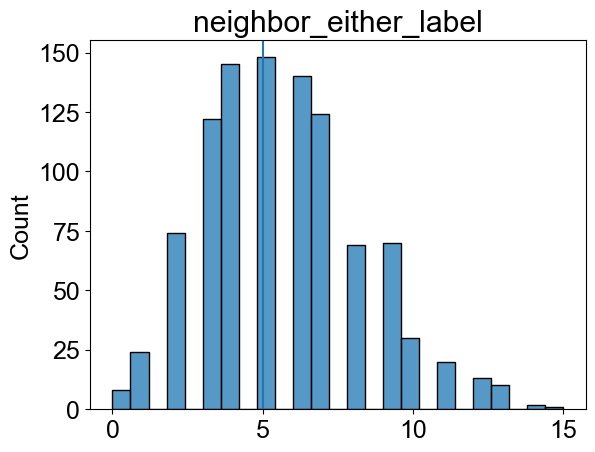

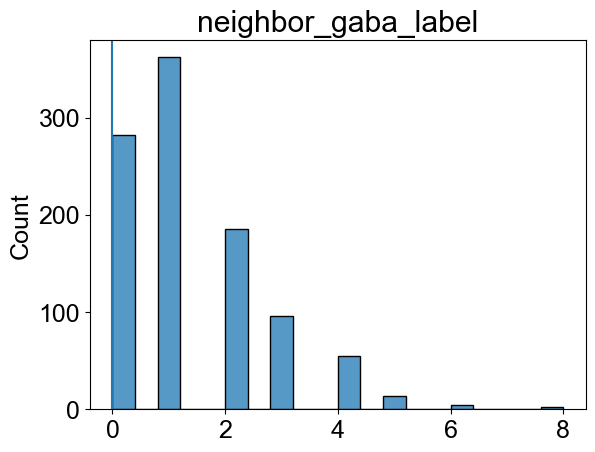

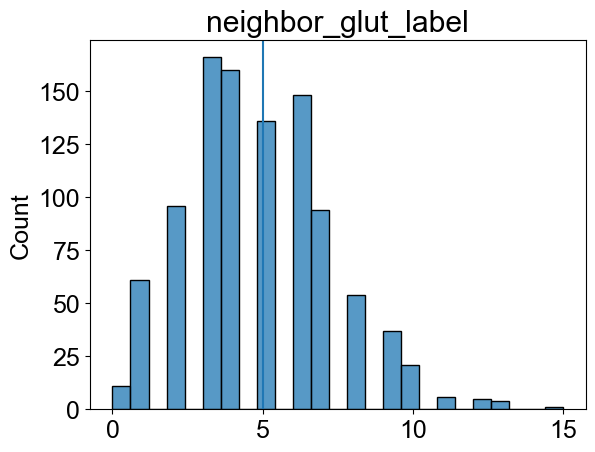

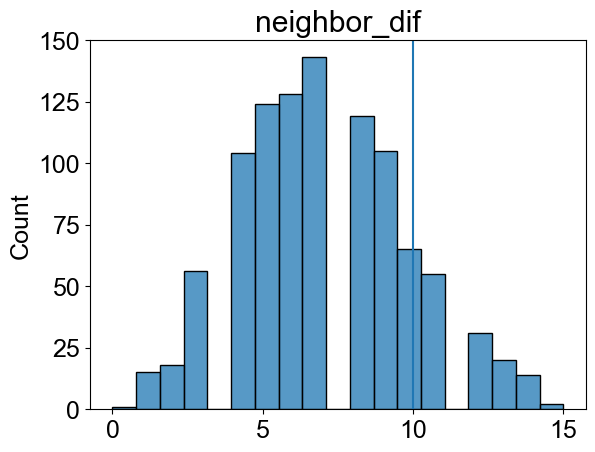

In [23]:
for key, value in results.items():
    vf , shuf_dist = value
    fig, ax=plt.subplots()
    sns.histplot(shuf_dist)
    ax.axvline(vf)
    ax.set(title=key)
    plt.show()
    

In [54]:
neuro_x_encode = neurompra.intersect(encodempra, wa=True)
neuro_x_encode_var = neurompra.intersect(encodeallelempra, wao=True)


res = pd.read_csv(neuro_x_encode.fn, sep='\t', header=None).drop_duplicates()
resvar = pd.read_csv(neuro_x_encode_var.fn, sep='\t',
                     header=None).drop_duplicates()

# rename columns
resvar.columns = ["#chr", "start.tile", "end.tile",
    "name"] + allele_col_order + ["overlap"]

res.shape, resvar.loc[resvar["overlap"] > 0].shape, len(set(resvar.loc[resvar["overlap"] > 0, "rsid"])), len(set(resvar.loc[(resvar["overlap"] > 0) &
                                                                                                             (resvar["adj.P.Val" <= 0.1), "rsid"]))

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (1330940777.py, line 12)

In [64]:
a = resvar.loc[(resvar["overlap"]>0)&
        (~resvar["adj.P.Val"].isna())]
a.loc[a["adj.P.Val"].astype(float)<=0.1, "rsid"].unique()
        #(resvar["adj.P.Val"].astype(float)<=0.1), "rsid"]))

array(['rs61853692', 'rs807052'], dtype=object)

In [18]:
support = pd.read_csv(SUPPORT, sep='\t')
support.head()

,name,tile.order,support_dif,support_dif_code,support_dif_name,neighbor_dif,neighbor_gaba_label,neighbor_glut_label,enh.name,neighbor_either_label
0,chr15:58748908-58749178,0.0,0,0,NaN,NaN,NaN,NaN,enh.566,None.None
1,chr15:58748928-58749198,1.0,0,0,NaN,NaN,NaN,NaN,enh.566,None.None
2,chr15:58748948-58749218,2.0,0,0,NaN,NaN,NaN,NaN,enh.566,None.None
3,chr15:58748968-58749238,3.0,0,0,NaN,NaN,NaN,NaN,enh.566,None.None
4,chr15:58748988-58749258,4.0,0,0,NaN,NaN,NaN,NaN,enh.566,None.None


In [48]:
neighbor_dif = set(support.loc[support["neighbor_dif"].astype(str)!="nan", "name"])
neighbor_gaba_label = set(support.loc[support["neighbor_gaba_label"].astype(str)!="nan", "name"])
neighbor_gaba_label_rest = set(support.loc[support["neighbor_gaba_label"].astype(str)=="nan", "name"])
neighbor_glut_label = set(support.loc[support["neighbor_glut_label"].astype(str)!="nan", "name"])
neighbor_glut_label_rest = set(support.loc[support["neighbor_glut_label"].astype(str)=="nan", "name"])
len(neighbor_dif), len(neighbor_gaba_label), len(neighbor_glut_label)

(9748, 1660, 6405)

In [49]:
for name_list in [neighbor_gaba_label,neighbor_gaba_label_rest, neighbor_glut_label, neighbor_glut_label_rest, neighbor_dif]:
    t = resvar.loc[(resvar['name'].isin(name_list)) &
           (resvar['overlap'] > 0), ["rsid", "adj.P.Val", "alt_ref_ratio"]].drop_duplicates()
    print(t.shape[0], 
         # t
         )

3
51
10
50
15
